# ARIMA, SARIMAX and AutoARIMA

ARIMA (AutoRegressive Integrated Moving Average) and its extension SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous estimators) are prominent and widely used statistical forecasting models.

In the ARIMA-SARIMAX model notation, the parameters $p$, $d$, and $q$ represent the autoregressive, differencing, and moving-average components, respectively. $P$, $D$, and $Q$ denote the same components for the seasonal part of the model, with $m$ representing the number of periods in each season.

+ $p$ is the order (number of time lags) of the autoregressive part of the model.

+ $d$ is the degree of differencing (the number of times that past values have been subtracted from the data).

+ $q$ is the order of the moving average part of the model.

+ $P$ is the order (number of time lags) of the seasonal part of the model.

+ $D$ is the degree of differencing (the number of times the data have had past values subtracted) of the seasonal part of the model.

+ $Q$ is the order of the moving average of the seasonal part of the model.

+ $m$ refers to the number of periods in each season.

When the terms $P$, $D$, $Q$, and $m$ are zero and no exogenous variables are included in the model, the SARIMAX model is equivalent to an ARIMA.

When two out of the three terms are zero, the model can be referred to based on the non-zero parameter, dropping "AR", "I" or "MA" from the acronym describing the model. For example, $ARIMA(1,0,0)$ is $AR(1)$, $ARIMA(0,1,0)$ is $I(1)$, and $ARIMA(0,0,1)$ is $MA(1)$.

<font size="6">ARIMA implementations</font>

**Skforecast** provide two clases that allow the creation of ARIMA family models:

+ [skforecast Sarimax](../api/stats.html#skforecast.stats._sarimax.Sarimax): A wrapper for the well-known **statsmodels SARIMAX** that strictly follows the scikit-learn API. Similar to pmdarima, this version has been streamlined to include only the essential elements required by skforecast, resulting in significant performance improvements.

+ [skforecast Arima](../api/stats.html#skforecast.stats._arima.Arima): A native implementation that also follows the scikit-learn API. This version is optimized for speed using Numba JIT compilation. It supports seasonal components, exogenous features, and automated parameter searching, making it a versatile tool for the entire ARIMA family: **ARIMA**, **SARIMAX**, and **AutoARIMA**.

## Libraries and data

In [20]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from skforecast.datasets import fetch_dataset
from skforecast.stats import Arima, Sarimax
from skforecast.recursive import ForecasterStats
from skforecast.model_selection import TimeSeriesFold, backtesting_stats
from skforecast.utils import expand_index
from skforecast.plot import set_dark_theme, plot_prediction_intervals
import warnings

set_dark_theme()
warnings.filterwarnings('once')

In [21]:
# Download data
# ==============================================================================
data = fetch_dataset(name="h2o_exog")
data.index.name = 'datetime'

╭─────────────────────────────────── h2o_exog ────────────────────────────────────╮
│ Description:                                                                    │
│ Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health   │
│ system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are │
│ simulated.                                                                      │
│                                                                                 │
│ Source:                                                                         │
│ Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd      │
│ Edition). http://pkg.robjhyndman.com/fpp3package/,                              │
│ https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.             │
│                                                                                 │
│ URL:                                                                            │
│ https://raw.githubusercontent.com/skforecast/skforecast-                        │
│ datasets/main/data/h2o_exog.csv                                                 │
│                                                                                 │
│ Shape: 195 rows x 3 columns                                                     │
╰─────────────────────────────────────────────────────────────────────────────────╯

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


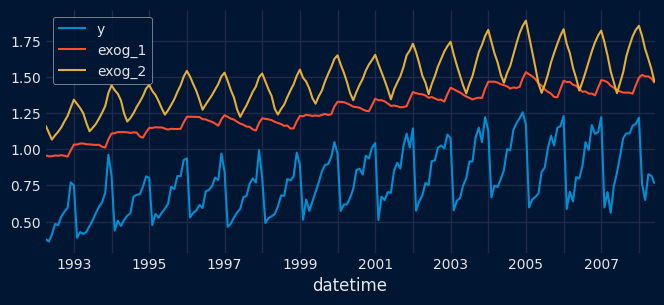

In [22]:
# Train-test dates
# ==============================================================================
end_train = '2005-06-01 23:59:59'

print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)

data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.plot(ax=ax)
ax.legend();

## Model definition and training

This section shows on how to create and train ARIMA models using each of the two classes available in skforecast.

In [76]:
# ARIMA model with skforecast wrapper of statsmodels
# ==============================================================================
model = Sarimax(order=(1, 0, 0), seasonal_order=(1, 1, 1, 12))
model.fit(y=data_train['y'])
model

,order,"(1, ...)"
,seasonal_order,"(1, ...)"
,trend,None
,measurement_error,False
,time_varying_regression,False
,mle_regression,True
,simple_differencing,False
,enforce_stationarity,True
,enforce_invertibility,True
,hamilton_representation,False
,concentrate_scale,False


In [24]:
# Model summary
# ==============================================================================
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  159
Model:              SARIMAX(12, 1, 1)   Log Likelihood                 234.019
Date:                Fri, 30 Jan 2026   AIC                           -440.038
Time:                        19:16:19   BIC                           -397.162
Sample:                    04-01-1992   HQIC                          -422.626
                         - 06-01-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0317      0.062     -0.513      0.608      -0.153       0.089
ar.L2         -0.0656      0.053     -1.248      0.212      -0.169       0.037
ar.L3         -0.0346      0.063     -0.551      0.582      -0.158       0.089
ar.L4         -0.0760      0.058     -1.307      0.191      -0.190       0.038
ar.L5         -0.0535      0.066     -0.808      0.419      -0.183       0.076
ar.L6         -0.0368      0.068     -0.542      0.588      -0.170       0.096
ar.L7         -0.0788      0.056     -1.401      0.161      -0.189       0.031
ar.L8         -0.0374      0.054     -0.693      0.488      -0.143       0.068
ar.L9         -0.0529      0.057     -0.922      0.356      -0.165       0.060
ar.L10        -0.0571      0.054     -1.054      0.292      -0.163       0.049
ar.L11         0.0112      0.054      0.209      0.835      -0.094       0.116
ar.L12         0.8600      0.045     18.930      0.000       0.771       0.949
ma.L1         -0.6204      0.089     -6.933      0.000      -0.796      -0.445
sigma2         0.0026      0.000      9.686      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 9.88
Prob(Q):                              0.34   Prob(JB):                         0.01
Heteroskedasticity (H):               1.54   Skew:                            -0.31
Prob(H) (two-sided):                  0.12   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
# ARIMA model with skforecast Arima classs
# ==============================================================================
model = Arima(order=(1, 0, 0), seasonal_order=(1, 1, 1), m=12)
model.fit(y=data_train['y'])
model

c:\Users\jaesc2\Miniconda3\envs\skforecast_py13\Lib\site-packages\skforecast\stats\arima\_arima_base.py:2571: UserWarning: Possible convergence problem. Try to increase 'maxiter' or change the optimization method.
  warnings.warn(


,order,"(1, ...)"
,seasonal_order,"(1, ...)"
,m,12
,include_mean,True
,transform_pars,True
,method,'CSS-ML'
,n_cond,None
,SSinit,'Gardner1980'
,optim_method,'BFGS'
,optim_kwargs,{'maxiter': 1000}
,kappa,1000000.0


<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>
Skforecast's ARIMA implementation is optimized for speed using just-in-time compilation with Numba. This makes that the first fit of the model is slower due to the compilation process, but subsequent fits and predictions are significantly faster compared the statsmodels implementation.
</p>
</div>

In [69]:
# Model summary
# ==============================================================================
model.summary()

ARIMA Model Summary
Model     : Arima(1,0,0)(1,1,1)[12]
Method    : ARIMA(1,0,0)(1,1,1)[12]
Converged : False

Coefficients:
------------------------------------------------------------
  ar1            :     0.6007  (SE:      nan, t:      nan)
  sar1           :     0.2211  (SE:      nan, t:      nan)
  sma1           :    -0.4229  (SE:      nan, t:      nan)

Model fit statistics:
  sigma^2:             0.003214
  Log-likelihood:      211.78
  AIC:                 -415.55
  BIC:                 N/A

Residual statistics:
  Mean:                0.016677
  Std Dev:             0.052063
  MAE:                 0.041167
  RMSE:                0.054512

Time Series Summary Statistics:
Number of observations: 159
  Mean:                 0.7471
  Std Dev:              0.2068
  Min:                  0.3618
  25%:                  0.5781
  Median:               0.7254
  75%:                  0.8955
  Max:                  1.2572


The following sections of this document utilize the native `skforecast.stats.Arima` implementation, as it offers superior performance for real-world use cases and it also implements the auto-arima process.

## Prediction

Once the model is fitted, it can be used to forecast future observations. It is important to note that these types of models require predictions to follow immediately after the training data; therefore, the forecast starts right after the last observed value.

In [70]:
# Predictions
# ==============================================================================
steps = len(data_test)
predictions = model.predict(steps=steps)
predictions

array([0.98311286, 0.97898595, 1.11311621, 1.16288209, 1.17991047,
       1.23701301, 1.15827032, 0.6033483 , 0.66304992, 0.67776462,
       0.71084794, 0.8378482 , 0.97830625, 0.9750425 , 1.10814365,
       1.15871796, 1.17182998, 1.23248541, 1.15549078, 0.60459012,
       0.6653501 , 0.67936218, 0.71429224, 0.83686955, 0.97724204,
       0.97416975, 1.10704378, 1.15779705, 1.1700434 , 1.23148436,
       1.15487623, 0.6048646 , 0.66585858, 0.67971534, 0.71505367,
       0.8366532 ])

For performance reasons, predictions are returned as NumPy arrays. These can be easily converted into Pandas Series by mapping them to the corresponding time index.

In [71]:
# Predictions as pandas Series
# ==============================================================================
pred_index = expand_index(index=data_train.index, steps=steps)
predictions = pd.Series(predictions, index=pred_index)
predictions.head(4)

2005-07-01    0.983113
2005-08-01    0.978986
2005-09-01    1.113116
2005-10-01    1.162882
Freq: MS, dtype: float64

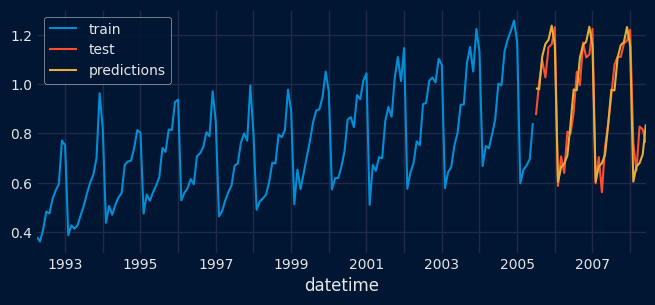

In [72]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [73]:
# Prediction error
# ==============================================================================
error_mae = mean_absolute_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mae): {error_mae}")

Test error (mae): 0.06214919383703984


## Prediction intervals

The method `predict_interval` enables the calculation of prediction intervals for the forecasted values. Users can specify the confidence level of the estimated interval using either the `alpha` or `interval` argument.

In [74]:
# Prediction intervals
# ==============================================================================
predictions = model.predict_interval(steps=steps, alpha=0.05)
predictions.index = pred_index
predictions.head(3)

,mean,lower_95,upper_95
2005-07-01,0.983113,0.853488,1.112737
2005-08-01,0.978986,0.843301,1.114670
2005-09-01,1.113116,0.975310,1.250922


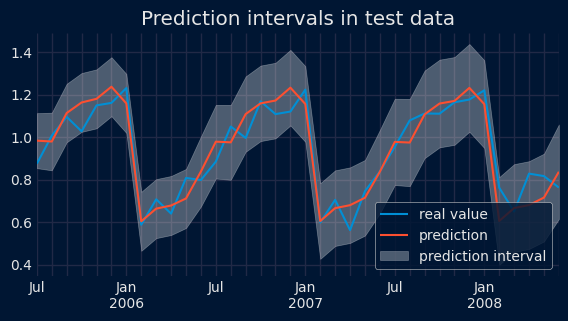

In [75]:
# Plot prediction intervals
# ==============================================================================
preds_to_plot = predictions.copy()
preds_to_plot = preds_to_plot.rename(
    columns={'mean': 'pred', 'lower_95': 'lower_bound', 'upper_95': 'upper_bound'}
)

fig, ax = plt.subplots(figsize=(6, 3))
plot_prediction_intervals(
    predictions         = preds_to_plot,
    y_true              = data_test,
    target_variable     = "y",
    title               = "Prediction intervals in test data",
    kwargs_fill_between = {'color': 'white', 'alpha': 0.3, 'zorder': 1},
    ax                  = ax
)

## Feature importances

The method `get_feature_importances` returns the coefficients of the model, which can be used as a measure of feature importance.

In [ ]:
# Feature importances
# ==============================================================================
model.get_feature_importances()

## AutoArima

**AutoArima** is an algorithm designed to automate the selection of optimal hyperparameters for an ARIMA model. The algorithm systematically evaluates various combinations of non-seasonal parameters ($p, d, q$), seasonal parameters ($P, D, Q$), and the seasonal period ($m$) to identify the configuration that best fits the data based on a specified criterion, typically the Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC).

With this estrategy, calculations are based solely on training data, eliminating the need for a separate data partition required by other strategies such as [grid search](../user_guides/hyperparameter-tuning-and-lags-selection.html). This makes the optimization process extremely efficient. However, it is important to note that information criteria only measure the relative quality of models within the defined search space. A model with the lowest AIC could still be a poor fit in absolute terms. Therefore, the selected model should ideally undergo a backtesting phase. This phase calculates forecast error metrics (such as MAE, MSE, or MAPE) to validate performance on a meaningful, interpretable scale.

Skforecast's [Arima](./forecasting-sarimax-arima.html) class triggers the AutoArima functionality whenever the `order` or `seasonal_order` arguments are set to `None`. After the model is fitted, the optimal parameters can be accessed via the `best_params_` attribute. For all subsequent predictions, the model automatically utilizes the optimal configuration identified during the fitting process.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

When evaluating ARIMA-SARIMAX models, it is important to note that AIC assumes that all models are trained on the same data. Thus, using AIC to decide between different orders of differencing is technically invalid, since one data point is lost with each order of differencing. Therefore, the Auto Arima algorithm uses a unit root test to select the order of differencing, and only uses the AIC to select the order of the AR and MA components.

For a detailed explanation of Akaike's Information Criterion (AIC) see <a href="https://robjhyndman.com/hyndsight/aic/">Rob J Hyndman's blog</a> and <a href="https://sites.warnercnr.colostate.edu/kenburnham/wp-content/uploads/sites/25/2016/08/AIC-Myths-and-Misunderstandings.pdf">AIC Myths and Misunderstandings by Anderson and Burnham</a>.

</div>

In [ ]:
# Skforecast Auto Arima
# ==============================================================================
auto_arima = Arima(
    order          = None,  # Must be None to use AutoArima
    seasonal_order = None,  # Must be None to use AutoArima
    start_p        = 0,
    start_q        = 0,
    max_p          = 12,
    max_q          = 5,
    max_P          = 5,
    max_Q          = 2,
    max_order      = 5,
    max_d          = 2,
    max_D          = 1,
    ic             = "aic",
    m              = 12,
    trace          = True,  # True for detailed information of the process
)
auto_arima.fit(y=data_train['y'], suppress_warnings=True)
auto_arima


Fitting models using approximations...

 ARIMA(0,0,0)(1,1,1)[12] with drift         : -421.1032
 ARIMA(0,0,0)(0,1,0)[12] with drift         : -406.4090
 ARIMA(1,0,0)(1,1,0)[12] with drift         : -433.3090
 ARIMA(0,0,1)(0,1,1)[12] with drift         : -433.0979
 ARIMA(0,0,0)(0,1,0)[12]                    : -363.4369
 ARIMA(1,0,0)(0,1,0)[12] with drift         : -428.0812
 ARIMA(1,0,0)(2,1,0)[12] with drift         : -403.2497
 ARIMA(1,0,0)(1,1,1)[12] with drift         : -446.8850
 ARIMA(1,0,0)(1,1,1)[12]                    : -415.5677
 ARIMA(1,0,0)(0,1,1)[12] with drift         : -442.2074
 ARIMA(1,0,0)(2,1,1)[12] with drift         : -448.0517
 ARIMA(1,0,0)(2,1,1)[12]                    : Inf
 ARIMA(1,0,0)(2,1,2)[12] with drift         : -445.9851
 ARIMA(1,0,0)(1,1,2)[12] with drift         : Inf
 ARIMA(0,0,0)(2,1,1)[12] with drift         : -419.4777
 ARIMA(2,0,0)(2,1,1)[12] with drift         : -462.1904
 ARIMA(2,0,0)(2,1,1)[12]                    : -450.8349
 ARIMA(2,0,0)(1,1,1

,order,None
,seasonal_order,None
,m,12
,include_mean,True
,transform_pars,True
,method,'CSS-ML'
,n_cond,None
,SSinit,'Gardner1980'
,optim_method,'BFGS'
,optim_kwargs,{'maxiter': 1000}
,kappa,1000000.0


In [ ]:
# Predictions
# ==============================================================================
steps = len(data_test)
predictions = auto_arima.predict(steps=steps)
pred_index = expand_index(index=data_train.index, steps=steps)
predictions = pd.Series(predictions, index=pred_index)
predictions.head(4)

2005-07-01    0.965375
2005-08-01    0.992160
2005-09-01    1.123179
2005-10-01    1.163022
Freq: MS, dtype: float64

Test error (mse): 0.08499561565395047


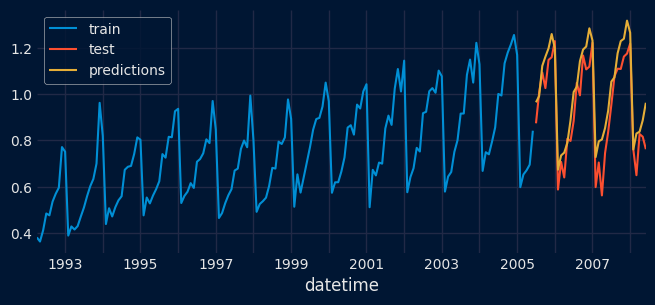

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

# Prediction error
# ==============================================================================
error_mae = mean_absolute_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mae): {error_mae}")

## Exogenous variables

The addition of exogenous variables is done using the `exog` argument. The only requirement for including an exogenous variable is the need to know the value of the variable also during the forecast period.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about exogenous variables and how to correctly manage them with skforecast visit: <a href="../user_guides/exogenous-variables.html">Exogenous variables (features) user guide</a>.

</div>

In [24]:
# Create and fit ForecasterStats with exogenous variables
# ==============================================================================
forecaster = ForecasterStats(
                 estimator=Arima(order=(12, 1, 1), seasonal_order=(0, 0, 0), m=1),
             )

forecaster.fit(
    y                 = data_train['y'], 
    exog              = data_train[['exog_1', 'exog_2']],
    suppress_warnings = True
)

# Predict with exog
# ==============================================================================
predictions = forecaster.predict(
                  steps = 36,
                  exog  = data_test[['exog_1', 'exog_2']]
              )
predictions.head(3)

2005-07-01    4.021546
2005-08-01    4.108299
2005-09-01    4.323374
Freq: MS, Name: pred, dtype: float64

## Prediction on training data (In-sample Predictions)

Predictions on the training data are crucial for evaluating the accuracy and effectiveness of the model. By comparing the predicted values wtih the actual observed values in the training dataset, you can assess how well the model has learned the underlying patterns and trends in the data. This comparison helps in understanding the model's performance and identify areas where it may need improvement or adjustment. In essence, they act as a mirror, reflecting how the model interprets and reconstructs the historical data on which it was trained.

Predictions of the observatios used to fit the mode are stored in the `fitted_values_` attribute of the `Arima` object.

In [23]:
# Create and fit ForecasterStats (skforecast)
# ==============================================================================
model = Arima(order=(1, 1, 1), seasonal_order=(1, 1, 1), m=12)
model.fit(y=data_train['y'], suppress_warnings=True)

# In-sample Predictions
# ==============================================================================
# Show only the first 5 values 
model.fitted_values_[:5]

array([0.37958872, 0.3617383 , 0.41046821, 0.48328403, 0.47539241])

## Backtesting

In time series forecasting, the process of [backtesting](./backtesting) consists of evaluating the performance of a predictive model by applying it retrospectively to historical data. To utilize the backtesting functionalities offered by skforecast with ARIMA models, the model must be used as an estimator within a [ForecasterStats](./forecasting-statistical-models.ipynb) object.

<div role="note"
    style="background: rgba(0,184,212,.08); border-left: 6px solid #00b8d4;
          border-radius: 6px; padding: 10px 12px; margin: 1em 0;">

<p style="display:flex; align-items:center; font-size:1rem; color:#00b8d4;
          margin:0 0 6px 0; font-weight:400;">
  <span style="margin-right:6px; font-size:18px;">✏️</span>
  <strong style="font-size:18px;">Note</strong>
</p>

<p style="margin:0 ; color:inherit;">
<b>Why do statistical models require refitting during backtesting?</b>
</p>

<p>
Unlike machine learning models, statistical models like ARIMA maintain an internal state that depends on the sequence of observations. They can only generate predictions starting from the last observed time step — they cannot "jump" to an arbitrary point in the future without knowing all previous values.

During backtesting, when the validation window moves forward, the model must be refitted to incorporate the new observations and update its internal state. This is why <code>refit=True</code> is typically required.

<b>Performance optimization:</b> Because refitting is mandatory, skforecast's Numba-optimized backend becomes essential. It enables hundreds of refits during backtesting in a fraction of the time required by non-optimized libraries.

<b>Exception:</b> The <code>skforecast.stats.Sarimax</code> model implements an efficient state-space representation that allows updating predictions without full model refitting.
</p>

</div>

In [27]:
# Backtest forecaster
# ======================================================================================
forecaster = ForecasterStats(estimator=Arima(order=(4, 0, 0), seasonal_order=(0, 1, 1), m=12))

cv = TimeSeriesFold(
         steps              = 12,  # predict 12 month per fold
         initial_train_size = len(data_train),
         refit              = True,
         fixed_train_size   = False,
     )

metric, predictions = backtesting_stats(
                          forecaster        = forecaster,
                          y                 = data['y'],
                          cv                = cv,
                          metric            = 'mean_absolute_error',
                          n_jobs            = 'auto',
                          suppress_warnings = True,
                          verbose           = True,
                          show_progress     = True
                      )
metric

Information of folds
--------------------
Number of observations used for initial training: 159
Number of observations used for backtesting: 36
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2006-06-01 00:00:00  (n=12)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2006-06-01 00:00:00  (n=171)
    Validation: 2006-07-01 00:00:00 -- 2007-06-01 00:00:00  (n=12)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2007-06-01 00:00:00  (n=183)
    Validation: 2007-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=12)



  0%|          | 0/3 [00:00<?, ?it/s]

,mean_absolute_error
0,0.056859


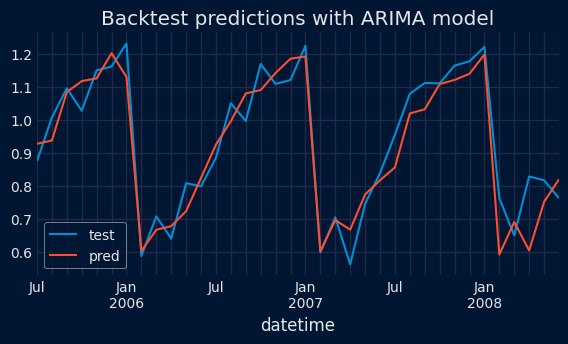

In [28]:
# Plot backtest predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_train:, 'y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax)
ax.set_title('Backtest predictions with ARIMA model')
ax.legend();

## Using an already trained ARIMA

Forecasting with an ARIMA model becomes challenging when the forecast horizon data does not immediately follow the last observed value during the training phase. This complexity is due to the moving average (MA) component, which relies on past forecast errors as predictors. Thus, to predict at time 't', the error of the 't-1' prediction becomes a necessity. In situations where this prediction isn't available, the corresponding error remains unavailable.

For this reason, in most cases, ARIMA models are retrained each time predictions need to be made. Despite considerable efforts and advances to speed up the training process for these models, it is not always feasible to retrain the model between predictions, either due to time constraints or insufficient computational resources for repeated access to historical data. An intermediate approach is to feed the model with data from the last training observation to the start of the prediction phase. This technique enables the estimation of intermediate predictions and, as a result, the necessary errors.

For example, imagine a situation where a model was trained 20 days ago with daily data from the past three years. When generating new predictions, only the 20 most recent values would be needed, rather than the complete historical dataset (365 * 3 + 20).

Integrating new data into the model can be complex, but the <code>ForecasterStats</code> class simplifies this considerably by automating the process through the `last_window` argument in its `predict` method.

<div role="note"
    style="background: rgba(0,184,212,.08); border-left: 6px solid #00b8d4;
          border-radius: 6px; padding: 10px 12px; margin: 1em 0;">

<p style="display:flex; align-items:center; font-size:1rem; color:#00b8d4;
          margin:0 0 6px 0; font-weight:400;">
  <span style="margin-right:6px; font-size:18px;">✏️</span>
  <strong style="font-size:18px;">Note</strong>
</p>

<p style="margin:0; color:inherit;">

This section only applies when using <code>skforecast.stats.Sarimax</code>, since this implementation does not require predictions to start right after the training data.
</p>

</div>

Train dates       : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Last window dates : 2005-07-01 00:00:00 --- 2007-06-01 00:00:00  (n=24)
Test dates        : 2007-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=12)


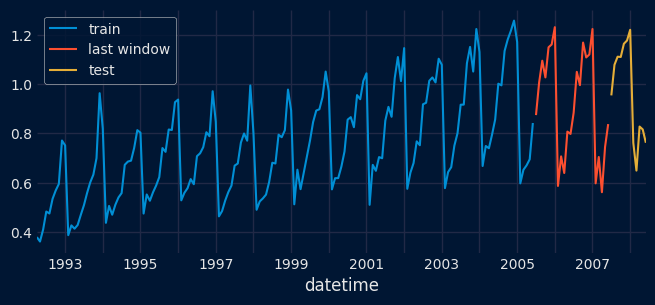

In [29]:
# Split data Train - Last window - Test
# ==============================================================================
end_train = '2005-06-01 23:59:59'
end_last_window = '2007-06-01 23:59:59'

print(
    f"Train dates       : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Last window dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_last_window].index.max()}  "
    f"(n={len(data.loc[end_train:end_last_window])})"
)
print(
    f"Test dates        : {data.loc[end_last_window:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_last_window:])})"
)
data_train       = data.loc[:end_train]
data_last_window = data.loc[end_train:end_last_window]
data_test        = data.loc[end_last_window:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_last_window['y'].plot(ax=ax, label='last window')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

Since exogenous variables have been included in the Forecaster tuning, it is necessary to pass both past values and their future values to the `predict` method using the `last_window_exog` and `exog` parameters when making predictions.

In [30]:
# Create and fit ForecasterStats with exogenous variables
# ==============================================================================
forecaster = ForecasterStats(
                 estimator=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

forecaster.fit(
    y                 = data_train['y'], 
    exog              = data_train[['exog_1', 'exog_2']],
    suppress_warnings = True
)

# Predict with exog and last window
# ==============================================================================
predictions = forecaster.predict(
                  steps            = 12,
                  exog             = data_test[['exog_1', 'exog_2']],
                  last_window      = data_last_window['y'],
                  last_window_exog = data_last_window[['exog_1', 'exog_2']]
              )
predictions.head(3)

2007-07-01    0.884144
2007-08-01    1.041033
2007-09-01    1.071151
Freq: MS, Name: pred, dtype: float64

In [ ]:
# Prediction error
# ==============================================================================
error_mae = mean_absolute_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mae): {error_mae}")

Test error (mse): 0.06275765564488678


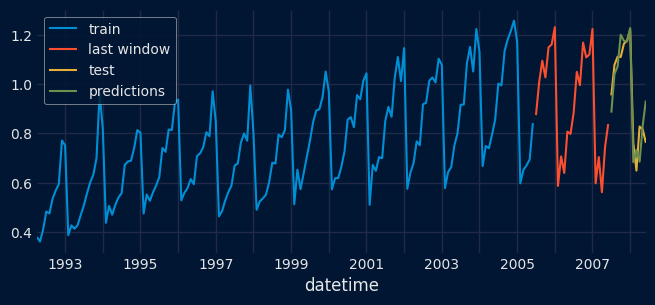

In [32]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_last_window['y'].plot(ax=ax, label='last window')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();